In [1]:
import os
import time
import torch
import math
import torchvision
from torchvision import transforms as transforms
from torch import nn
from torch.nn import functional as F

import matplotlib.pyplot as plt
import numpy as np
import random

torch.cuda.empty_cache()

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.manual_seed(17)
torch.cuda.manual_seed_all(17)

aug_train = transforms.Compose([
    transforms.RandomCrop(32,padding=4,padding_mode='reflect'),
    transforms.RandomHorizontalFlip(), # 水平翻转
    transforms.ToTensor(),
    transforms.Normalize((0.4244, 0.4146, 0.3836), (0.2539, 0.2491, 0.2420)) # normalization
    ])

aug_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4244, 0.4146, 0.3836), (0.2539, 0.2491, 0.2420)) # normalization
    ])

trainingdata = torchvision.datasets.CIFAR10('./CIFAR10',train=True,download=True,transform=aug_train)

Files already downloaded and verified


In [4]:
def load_data(is_train,aug,batch_size):
    dataset = torchvision.datasets.CIFAR10('./CIFAR10',train=is_train,download=True,transform=aug)
#   mean, std = get_mean_and_std(dataset)
#   print(mean, std)
    dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=is_train)
    return dataloader

batch_size = 256 # param
trainDataLoader = load_data(is_train=True,aug=aug_train,batch_size=batch_size)
testDataLoader = load_data(is_train=False,aug=aug_test,batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 32, 32]) 6


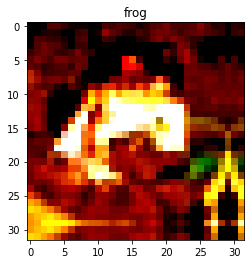

In [5]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

image,label = trainingdata[0]
print(image.shape, label)

%matplotlib inline
plt.imshow(image.numpy().transpose(1,2,0))
plt.title(str(classes[label]))
plt.show()

In [6]:
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
#         self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(1024, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
#         print(x.shape)
        out = F.relu(self.bn1(self.conv1(x)))
#         print(out.shape)
        out = self.layer1(out)
#         print(out.shape)
        out = self.layer2(out)
#         print(out.shape)
        out = self.layer3(out)
#         print(out.shape)
#         out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
#         print(out.shape)
        out = out.view(out.size(0), -1)
#         print(out.shape)
        out = self.linear(out)
        return out
    
    def init_weights(self):
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,mode='fan_out',nonlinearity='relu') # weight initialization
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.BatchNorm2d):
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.Linear):
                nn.init.normal_(m.weight,std=1e-3)
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)

def project1_model():
#     return ResNet(BasicBlock, [2, 2, 2, 2])
    return ResNet(BasicBlock, [3, 3, 3])

# model1 = nn.Sequential(project1_model(), nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(), nn.Linear(512, 10)).cuda()
model1 = project1_model().cuda()
model1.init_weights()

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    # torch.numel() returns number of elements in a tensor

print(count_parameters(model1))

4335434


In [9]:
num_epochs = 1000 # param
epoch_start = 0
path = 'resnet_aug_weight_decay.pt'

train_loss_history = []
test_loss_history = []
test_accuracy_history = []

Loss = torch.nn.CrossEntropyLoss()
lr = 0.1 # param
weight_decay = 1e-4
optimizer = torch.optim.SGD(model1.parameters(),lr=lr,momentum=0.9,weight_decay=weight_decay) # changable optimizer

if os.path.exists(path):
    checkpoint = torch.load(path)
    print('Read model from checkpoint')
    model1.cuda().load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch_start = checkpoint['epoch']
    Loss = checkpoint['Loss']
    train_loss_history = checkpoint['train_loss_history']
    test_loss_history = checkpoint['test_loss_history']
    test_accuracy_history = checkpoint['test_accuracy_history']
    print('Restart from epoch',epoch_start)
    

for epoch in range(epoch_start+1, num_epochs+1):
    timestart = time.time()

    train_loss = 0.0
    test_loss = 0.0
    test_accuracy = 0.0

    for i, data in enumerate(trainDataLoader):
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        predicted_output = model1.cuda()(images)
        fit = Loss(predicted_output,labels)
        fit.backward()
        optimizer.step()
        train_loss += fit.item()

    for i, data in enumerate(testDataLoader):
        with torch.no_grad():
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            predicted_output = model1.cuda()(images)
            fit = Loss(predicted_output,labels)
            test_loss += fit.item()
            test_accuracy += (torch.eq(torch.max(predicted_output,1)[1],labels).sum()/len(labels)*100).data.cpu().numpy()


    train_loss = train_loss/len(trainDataLoader)
    test_loss = test_loss/len(testDataLoader)
    test_accu = test_accuracy/len(testDataLoader)
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    test_accuracy_history.append(test_accu)
    print('Epoch %s, Train loss %s, Test loss %s, Test accuracy %s, Cost %s s'%(epoch,train_loss,test_loss,test_accu,time.time()-timestart))

    if epoch % 5 == 0 and epoch != 0:
        torch.save({'epoch':epoch,
              'model_state_dict':model1.cuda().state_dict(),
              'optimizer_state_dict':optimizer.state_dict(),
              'Loss':Loss,
              'train_loss_history':train_loss_history,
              'test_loss_history':test_loss_history,
              'test_accuracy_history':test_accuracy_history},path)
        print('Model saved in epoch %s'%(epoch))

Read model from checkpoint
Restart from epoch 500
Epoch 501, Train loss 0.03374898353382489, Test loss 0.31314371302723887, Test accuracy 92.3828125, Cost 52.57499432563782 s
Epoch 502, Train loss 0.038501406050458244, Test loss 0.3010561387985945, Test accuracy 92.451171875, Cost 52.57318925857544 s
Epoch 503, Train loss 0.042486081935693414, Test loss 0.2982605967670679, Test accuracy 92.451171875, Cost 52.59165644645691 s
Epoch 504, Train loss 0.03752754098374625, Test loss 0.29687433019280435, Test accuracy 92.314453125, Cost 52.616886377334595 s
Epoch 505, Train loss 0.030602500983038728, Test loss 0.2992273334413767, Test accuracy 92.353515625, Cost 52.56173753738403 s
Model saved in epoch 505
Epoch 506, Train loss 0.028567936076611584, Test loss 0.3175880003720522, Test accuracy 92.4609375, Cost 52.54379630088806 s
Epoch 507, Train loss 0.047139092980484874, Test loss 0.304410195723176, Test accuracy 92.05078125, Cost 52.61023688316345 s
Epoch 508, Train loss 0.04632918947680416

Epoch 564, Train loss 0.044311247618716895, Test loss 0.2980454910546541, Test accuracy 92.236328125, Cost 52.739235162734985 s
Epoch 565, Train loss 0.044685145721257646, Test loss 0.30677397139370444, Test accuracy 92.177734375, Cost 52.74429249763489 s
Model saved in epoch 565
Epoch 566, Train loss 0.032117963566596866, Test loss 0.3084982126951218, Test accuracy 92.5, Cost 52.7007999420166 s
Epoch 567, Train loss 0.03264513639828228, Test loss 0.2919411674141884, Test accuracy 92.568359375, Cost 52.71148991584778 s
Epoch 568, Train loss 0.03455022396757362, Test loss 0.30115782991051676, Test accuracy 92.666015625, Cost 52.702903509140015 s
Epoch 569, Train loss 0.0414473473721621, Test loss 0.32252622991800306, Test accuracy 92.099609375, Cost 52.71967911720276 s
Epoch 570, Train loss 0.03799566894304007, Test loss 0.303499935567379, Test accuracy 92.490234375, Cost 52.72026085853577 s
Model saved in epoch 570
Epoch 571, Train loss 0.0374819342598167, Test loss 0.3572248887270689,

Epoch 627, Train loss 0.03549055248612956, Test loss 0.34715038128197195, Test accuracy 91.66015625, Cost 75.27736926078796 s
Epoch 628, Train loss 0.030293308329122255, Test loss 0.306088050827384, Test accuracy 92.265625, Cost 75.26872134208679 s
Epoch 629, Train loss 0.03945276928514394, Test loss 0.32875496074557303, Test accuracy 92.099609375, Cost 75.11673903465271 s
Epoch 630, Train loss 0.03398229707536116, Test loss 0.3279669348150492, Test accuracy 92.353515625, Cost 75.33920001983643 s
Model saved in epoch 630
Epoch 631, Train loss 0.03269588829455327, Test loss 0.2948714304715395, Test accuracy 92.705078125, Cost 75.45752477645874 s
Epoch 632, Train loss 0.03582675476102348, Test loss 0.3268939547240734, Test accuracy 91.904296875, Cost 75.51274156570435 s
Epoch 633, Train loss 0.036557741952603875, Test loss 0.2964804593473673, Test accuracy 92.431640625, Cost 75.26331782341003 s
Epoch 634, Train loss 0.03627953207481424, Test loss 0.30287802703678607, Test accuracy 92.675

Epoch 690, Train loss 0.03730291668420695, Test loss 0.3225305858999491, Test accuracy 91.9921875, Cost 75.27215456962585 s
Model saved in epoch 690
Epoch 691, Train loss 0.042548939143782674, Test loss 0.294383106008172, Test accuracy 92.529296875, Cost 75.54316735267639 s
Epoch 692, Train loss 0.035486952755695245, Test loss 0.31421588733792305, Test accuracy 92.080078125, Cost 75.38816332817078 s
Epoch 693, Train loss 0.03552386840586835, Test loss 0.3137892082333565, Test accuracy 92.275390625, Cost 75.2848391532898 s
Epoch 694, Train loss 0.034420290194470814, Test loss 0.29365326799452307, Test accuracy 92.55859375, Cost 75.37705063819885 s
Epoch 695, Train loss 0.0337124996538255, Test loss 0.30138207525014876, Test accuracy 92.67578125, Cost 75.3152666091919 s
Model saved in epoch 695
Epoch 696, Train loss 0.036766986227214186, Test loss 0.30650751292705536, Test accuracy 92.6171875, Cost 75.33427095413208 s
Epoch 697, Train loss 0.03939464536961168, Test loss 0.300516563281416

Epoch 753, Train loss 0.042981423656171074, Test loss 0.2954979345202446, Test accuracy 92.763671875, Cost 75.22745370864868 s
Epoch 754, Train loss 0.028608429122107978, Test loss 0.31823594532907007, Test accuracy 91.962890625, Cost 75.45022749900818 s
Epoch 755, Train loss 0.04037706996789392, Test loss 0.30496673844754696, Test accuracy 92.509765625, Cost 75.3848009109497 s
Model saved in epoch 755
Epoch 756, Train loss 0.030767265229714007, Test loss 0.29871479868888856, Test accuracy 92.607421875, Cost 75.39547824859619 s
Epoch 757, Train loss 0.033977203642502805, Test loss 0.3319988053292036, Test accuracy 92.001953125, Cost 75.3574104309082 s
Epoch 758, Train loss 0.046290521025277524, Test loss 0.3244657203555107, Test accuracy 92.353515625, Cost 75.24161195755005 s
Epoch 759, Train loss 0.03552944695206397, Test loss 0.2968258481472731, Test accuracy 92.265625, Cost 75.47114515304565 s
Epoch 760, Train loss 0.03649936978733737, Test loss 0.32756319269537926, Test accuracy 92

Epoch 816, Train loss 0.031275725735788594, Test loss 0.3089366026222706, Test accuracy 92.255859375, Cost 75.36726880073547 s
Epoch 817, Train loss 0.039251839190873564, Test loss 0.3012573217973113, Test accuracy 92.470703125, Cost 75.27946829795837 s
Epoch 818, Train loss 0.0408995861700755, Test loss 0.3059467777609825, Test accuracy 92.5, Cost 75.16335844993591 s
Epoch 819, Train loss 0.030933471256391887, Test loss 0.32870140075683596, Test accuracy 92.16796875, Cost 75.364497423172 s
Epoch 820, Train loss 0.03557318157506917, Test loss 0.2973128464072943, Test accuracy 92.587890625, Cost 75.28037667274475 s
Model saved in epoch 820
Epoch 821, Train loss 0.03567914573038567, Test loss 0.2980306684970856, Test accuracy 92.568359375, Cost 75.33055973052979 s
Epoch 822, Train loss 0.04256302714157773, Test loss 0.2895066637545824, Test accuracy 92.685546875, Cost 75.13370990753174 s
Epoch 823, Train loss 0.039000733114056746, Test loss 0.29708135053515433, Test accuracy 92.32421875,

Epoch 879, Train loss 0.03455113691553397, Test loss 0.30863346457481383, Test accuracy 92.4609375, Cost 75.35678267478943 s
Epoch 880, Train loss 0.04095643769227424, Test loss 0.3199481338262558, Test accuracy 92.001953125, Cost 75.40053606033325 s
Model saved in epoch 880
Epoch 881, Train loss 0.04278035783113874, Test loss 0.3103916812688112, Test accuracy 92.24609375, Cost 75.19614052772522 s
Epoch 882, Train loss 0.029196445915695965, Test loss 0.2950376706197858, Test accuracy 92.822265625, Cost 75.35129475593567 s
Epoch 883, Train loss 0.027026967588593537, Test loss 0.3389972347766161, Test accuracy 92.373046875, Cost 75.3354549407959 s
Epoch 884, Train loss 0.0386377761392303, Test loss 0.29978464879095557, Test accuracy 92.7734375, Cost 75.3093614578247 s
Epoch 885, Train loss 0.03756159670384867, Test loss 0.29401534162461757, Test accuracy 92.451171875, Cost 75.28239345550537 s
Model saved in epoch 885
Epoch 886, Train loss 0.04152749156180237, Test loss 0.3015086632221937

Epoch 942, Train loss 0.032952871439712386, Test loss 0.334079560264945, Test accuracy 92.421875, Cost 75.28151249885559 s
Epoch 943, Train loss 0.03234162605937799, Test loss 0.31633838936686515, Test accuracy 92.44140625, Cost 75.29432010650635 s
Epoch 944, Train loss 0.03262309087392855, Test loss 0.31881080456078054, Test accuracy 92.71484375, Cost 75.32792139053345 s
Epoch 945, Train loss 0.030122127239022176, Test loss 0.31195767447352407, Test accuracy 92.4609375, Cost 75.31935048103333 s
Model saved in epoch 945
Epoch 946, Train loss 0.03986499772160029, Test loss 0.32645915299654005, Test accuracy 92.265625, Cost 75.39224481582642 s
Epoch 947, Train loss 0.04232731910793073, Test loss 0.26666993498802183, Test accuracy 93.076171875, Cost 75.3376317024231 s
Epoch 948, Train loss 0.029093880569847415, Test loss 0.29179827831685545, Test accuracy 92.91015625, Cost 75.2648503780365 s
Epoch 949, Train loss 0.03226745372391021, Test loss 0.3023687232285738, Test accuracy 92.3046875,

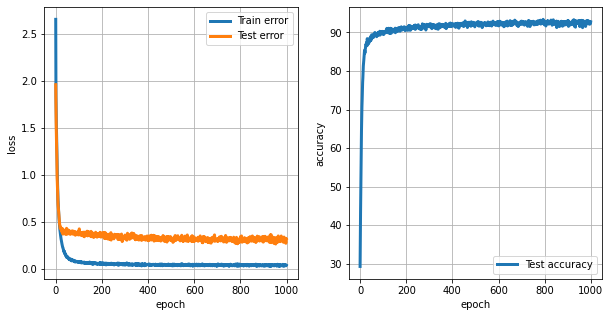

In [10]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(range(num_epochs),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(num_epochs),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(num_epochs),test_accuracy_history,'-',linewidth=3,label='Test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend()

In [11]:
print('Accuracy:',sum(test_accuracy_history[-5:])/5,100-sum(test_accuracy_history[-5:])/5)

Accuracy: 92.470703125 7.529296875
